<a href="https://colab.research.google.com/github/swarthyPig/Raspberry-Pi_DHT22_Weather_Station_with_correlation-and-ML/blob/master/machine%20learning/Keras_MRL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

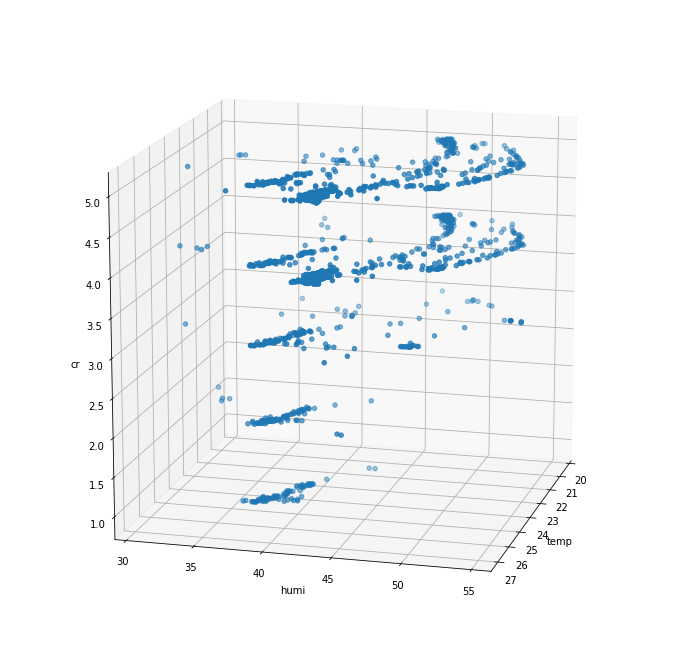

In [38]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import RMSprop

import numpy as np
from pandas.io.parsers import read_csv
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

data = read_csv('iot_data.csv', sep=',')

data = np.array(data, dtype=np.float32)

xs = np.array(data[:,1], dtype=np.float32)
ys = np.array(data[:,2], dtype=np.float32)
zs = np.array(data[:,-1], dtype=np.float32)

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, zs)
ax.set_xlabel('temp')
ax.set_ylabel('humi')
ax.set_zlabel('cr')
ax.view_init(15, 15)

plt.show()

In [39]:
# data split
from sklearn.model_selection import train_test_split

x_data = data[0:-1, 1:-1] # temp, humi

y_data = data[0:-1, [-1]] # cr

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, 
                                                    test_size=0.2, random_state=0)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1192, 2)
(1192, 1)
(299, 2)
(299, 1)


In [40]:
rmsprop = RMSprop(lr=0.01)

model = Sequential()
model.add(Dense(1, input_shape=(2,)))
model.compile(loss='mse', optimizer=rmsprop, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [0]:
hist = model.fit(x_train, y_train, epochs = 2000, verbose=0)

In [42]:
print('## training loss and acc ##')
# print(hist.history['loss'])
# print(hist.history['acc'])


## training loss and acc ##


In [43]:
# list all data in history
print(hist.history.keys())

dict_keys(['loss', 'acc'])


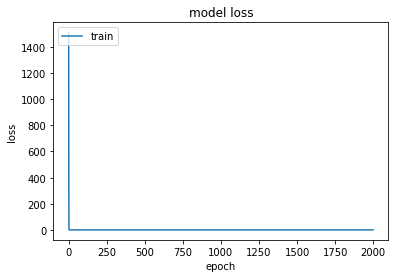

In [44]:
# summarize history for loss
plt.plot(hist.history['loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [45]:
np.mean(hist.history['acc'])  # Not good!

0.35811367449664433

In [47]:
# model에 임의의 값을 넣어 test
#model.predict(x_train)
model.predict(np.array([23,43]).reshape(1,2))

array([[3.4307842]], dtype=float32)

In [48]:
# 모델평가
test_loss, test_acc = model.evaluate(x_test, y_test)
print('정확도 :', test_acc)

299/299 [==============================] - 0s 135us/step
정확도 : 0.3645484954816442


In [49]:
# get weight, bias value
W_, b_ = model.get_weights()
print(W_)
print('weigth : ', W_[0],W_[1]) 
print('bias : ', b_)

[[0.08581936]
 [0.11016191]]
weigth :  [0.08581936] [0.11016191]
bias :  [-3.280023]


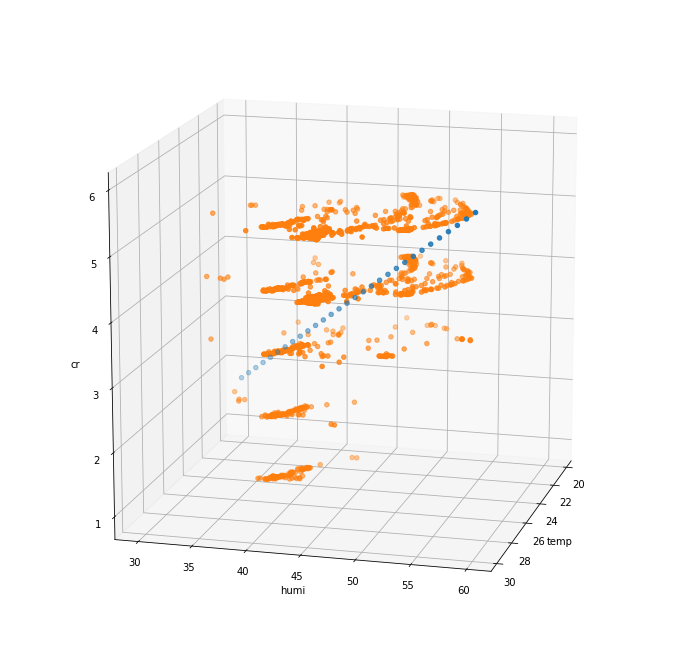

In [50]:
x = np.linspace(20, 30, 30).reshape(30,1) # Temp range(20~30, 간격:30)
y = np.linspace(30, 60, 30).reshape(30,1) # Humi range(30~60, 간격:30)

X = np.concatenate((x,y), axis=1)
Z = np.matmul(X, W_) + b_

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, Z)
ax.scatter(xs, ys, zs)
ax.set_xlabel('temp')
ax.set_ylabel('humi')
ax.set_zlabel('cr')
ax.view_init(15, 15)

plt.show()

### New keras model

In [0]:
# Keras
# from keras.models import Sequential
# from keras.layers import Dense
import keras
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

In [52]:
x_data.shape,x_train.shape,y_train.shape,x_test.shape,y_test.shape

((1491, 2), (1192, 2), (1192, 1), (299, 2), (299, 1))

### Simple model - one layer

In [76]:
# create simple model with light model capacity 
model_s = Sequential()  # simple model

#get number of columns in training data
n_cols = x_train.shape[1]
print(n_cols)
#add layers to model
model_s.add(Dense(10, activation='relu', input_shape=(n_cols,)))
# model_s.add(Dense(10, activation='relu'))
model_s.add(Dense(1, activation='relu'))

2


In [77]:
model_s.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 10)                30        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 11        
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


In [0]:
# The EarlyStopping callback monitors training accuracy:
# if it fails to improve for 3, 5 or 10 consecutive epochs,
# training stops early
# and save the best model
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model_s.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)  # monitor='acc', patience=3
]

In [0]:
# compile model using mse as a measure of model performance
model_s.compile(optimizer='adam', loss='mean_squared_error')

# set early stopping monitor so the model stops training when it won't improve anymore
early_stopping_monitor = EarlyStopping(patience=3)

In [81]:
# train model with all data
model_s.fit(x_train, y_train, validation_split=0.25, 
            epochs=50, callbacks=callbacks_list)

print('\nAccuracy: {:.4f}'.format(model_s.evaluate(x_test, y_test)))

Train on 894 samples, validate on 298 samples
Epoch 1/50
894/894 [==============================] - 0s 41us/step - loss: 1.0744 - val_loss: 1.2253
Epoch 2/50
894/894 [==============================] - 0s 33us/step - loss: 1.0679 - val_loss: 1.2716
Epoch 3/50
894/894 [==============================] - 0s 33us/step - loss: 1.0787 - val_loss: 1.2337
Epoch 4/50
894/894 [==============================] - 0s 33us/step - loss: 1.0789 - val_loss: 1.2242
Epoch 5/50
894/894 [==============================] - 0s 31us/step - loss: 1.0738 - val_loss: 1.2278
Epoch 6/50
894/894 [==============================] - 0s 35us/step - loss: 1.0807 - val_loss: 1.2405
Epoch 7/50
894/894 [==============================] - 0s 34us/step - loss: 1.0901 - val_loss: 1.2242
Epoch 8/50
894/894 [==============================] - 0s 32us/step - loss: 1.1182 - val_loss: 1.2468
Epoch 9/50
894/894 [==============================] - 0s 33us/step - loss: 1.0740 - val_loss: 1.2387
Epoch 10/50
894/894 [========================

### Increase model capacity

In [0]:
# training a new model on the same data to show the effect of increasing model capacity
model_b = Sequential()

#get number of columns in training data
n_cols = x_train.shape[1]

#add model layers
model_b.add(Dense(200, activation='relu', input_shape=(n_cols,)))
model_b.add(Dense(100, activation='relu'))
model_b.add(Dense(20, activation='relu'))
model_b.add(Dense(1, activation='relu'))

In [83]:
model_b.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 200)               600       
_________________________________________________________________
dense_13 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_14 (Dense)             (None, 20)                2020      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 21        
Total params: 22,741
Trainable params: 22,741
Non-trainable params: 0
_________________________________________________________________


In [0]:
# The EarlyStopping callback monitors training accuracy:
# if it fails to improve for 3, 5 or 10 consecutive epochs,
# training stops early
# and save the best model
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model_b.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)  # monitor='acc', patience=3
]

In [0]:
# compile model using mse as a measure of model performance
model_b.compile(loss='mean_squared_error', optimizer='adam',
              metrics=['accuracy'])   # loss='sparse_categorical_crossentropy', 'mean_squared_error'

In [86]:
hist = model_b.fit(x_train, y_train, validation_data=(x_test, y_test),epochs=100, 
                   batch_size=50, callbacks=callbacks_list)

print('\nAccuracy: {:.4f}'.format(model_b.evaluate(x_test, y_test)[1]))

Train on 1192 samples, validate on 299 samples
Epoch 1/100
1192/1192 [==============================] - 0s 360us/step - loss: 17.2483 - acc: 0.0000e+00 - val_loss: 16.7860 - val_acc: 0.0000e+00
Epoch 2/100
1192/1192 [==============================] - 0s 45us/step - loss: 17.2483 - acc: 0.0000e+00 - val_loss: 16.7860 - val_acc: 0.0000e+00
Epoch 3/100
1192/1192 [==============================] - 0s 43us/step - loss: 17.2483 - acc: 0.0000e+00 - val_loss: 16.7860 - val_acc: 0.0000e+00
Epoch 4/100
1192/1192 [==============================] - 0s 43us/step - loss: 17.2483 - acc: 0.0000e+00 - val_loss: 16.7860 - val_acc: 0.0000e+00
Epoch 5/100
1192/1192 [==============================] - 0s 44us/step - loss: 17.2483 - acc: 0.0000e+00 - val_loss: 16.7860 - val_acc: 0.0000e+00
Epoch 6/100
299/299 [==============================] - 0s 45us/step

Accuracy: 0.0000


> val_loss가 현저히 줄어듬 -> 모델 

### Performance of model_s and model_b

> Split dataframe into the train and test set

In [65]:
# get predictions
y_pred = model_s.predict(x_test)
y_pred[:5].ravel()

array([0., 0., 0., 0., 0.], dtype=float32)

In [66]:
y_pred.ravel()

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

> model_s is NOT good!

In [67]:
# get predictions
y_pred = model_b.predict(x_test)
y_pred[:5]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

In [68]:
print(y_pred.ravel())
print(y_test.ravel())

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[3. 4. 2. 3. 5. 4. 5. 5. 5. 5. 5. 4. 4. 2. 4. 4. 5. 5. 4. 4. 4. 4. 4. 5.
 5. 2. 4. 5. 5. 

# Check model_b

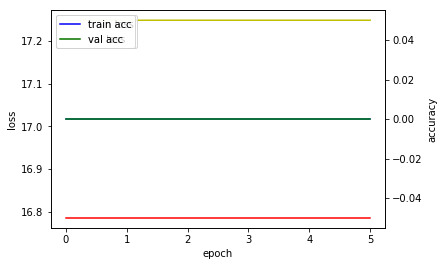

In [70]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

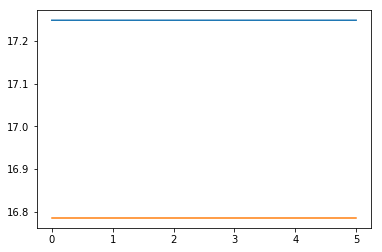

In [71]:
# Plot performance
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()

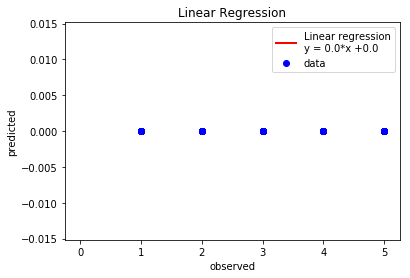

In [72]:
# print the linear regression and display datapoints
from sklearn.linear_model import LinearRegression  
regressor = LinearRegression()  
true_y=y_test #[:,np.newaxis] # np.argmax(y_test, axis=1)  # decode one-hot encoding
regressor.fit(true_y, y_pred)  
y_fit = regressor.predict(y_pred) 

reg_intercept = round(regressor.intercept_[0],4)
reg_coef = round(regressor.coef_.flatten()[0],4)
reg_label = "y = " + str(reg_intercept) + "*x +" + str(reg_coef)

plt.scatter(true_y, y_pred, color='blue', label= 'data')
plt.plot(y_pred, y_fit, color='red', linewidth=2, label = 'Linear regression\n'+reg_label) 
plt.title('Linear Regression')
plt.legend()
plt.xlabel('observed')
plt.ylabel('predicted')
plt.show()

In [73]:
# 모델평가
test_loss, test_acc = model_b.evaluate(x_test, y_test)
print('정확도 :', test_acc)

299/299 [==============================] - 0s 37us/step
정확도 : 0.0


***

In [0]:
# import keras

In [0]:
# #-----------------------------------------------------------------_______------------
# # Define custom loss functions for regression in Keras 
# #
# # The functions below are Keras backend tensor functions 
# # and can be used for Keras loss functions, Keras metrics and Keras learning curves. 
# #------------------------------------------------------------------_______-----------
# # https://github.com/keras-team/keras/issues/7947

# # root mean squared error (rmse) for regression (only for Keras tensors)
# def rmse(y_true, y_pred):
#     from keras import backend
#     return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

# # mean squared error (mse) for regression  (only for Keras tensors)
# def mse(y_true, y_pred):
#     from keras import backend
#     return backend.mean(backend.square(y_pred - y_true), axis=-1)

# # coefficient of determination (R^2) for regression  (only for Keras tensors)
# def r_square(y_true, y_pred):
#     from keras import backend as K
#     SS_res =  K.sum(K.square(y_true - y_pred)) 
#     SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
#     return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# def r_square_loss(y_true, y_pred):
#     from keras import backend as K
#     SS_res =  K.sum(K.square(y_true - y_pred)) 
#     SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
#     return 1 - ( 1 - SS_res/(SS_tot + K.epsilon()))
